# Artificial Neural Networks and Deep Learning

---

## The Bergers: Francesco Palma, Francesco Pellegrini, Luigi Raggi

## ⚙️ Import Libraries

In [73]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/[2024-2025] AN2DL/Homework 2

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/[2024-2025] AN2DL/Homework 2


In [74]:
from datetime import datetime
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
import tensorflow.keras.backend as K
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import ListedColormap, BoundaryNorm
import random
import albumentations as A

np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## ⏳ Load the Data

In [75]:
data = np.load("mars_for_students.npz")

training_set = data["training_set"]
X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

print(f"Training X shape: {X_train.shape}")
print(f"Training y shape: {y_train.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2615, 64, 128)
Training y shape: (2615, 64, 128)
Test X shape: (10022, 64, 128)


## Inspect Data

In [76]:
# Define a custom colormap for the classes
class_labels = {
    0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
}
cmap = ListedColormap(["black", "brown", "gray", "yellow", "green"])
norm = BoundaryNorm(boundaries=[-0.5, 0.5, 1.5, 2.5, 3.5, 4.5], ncolors=5)

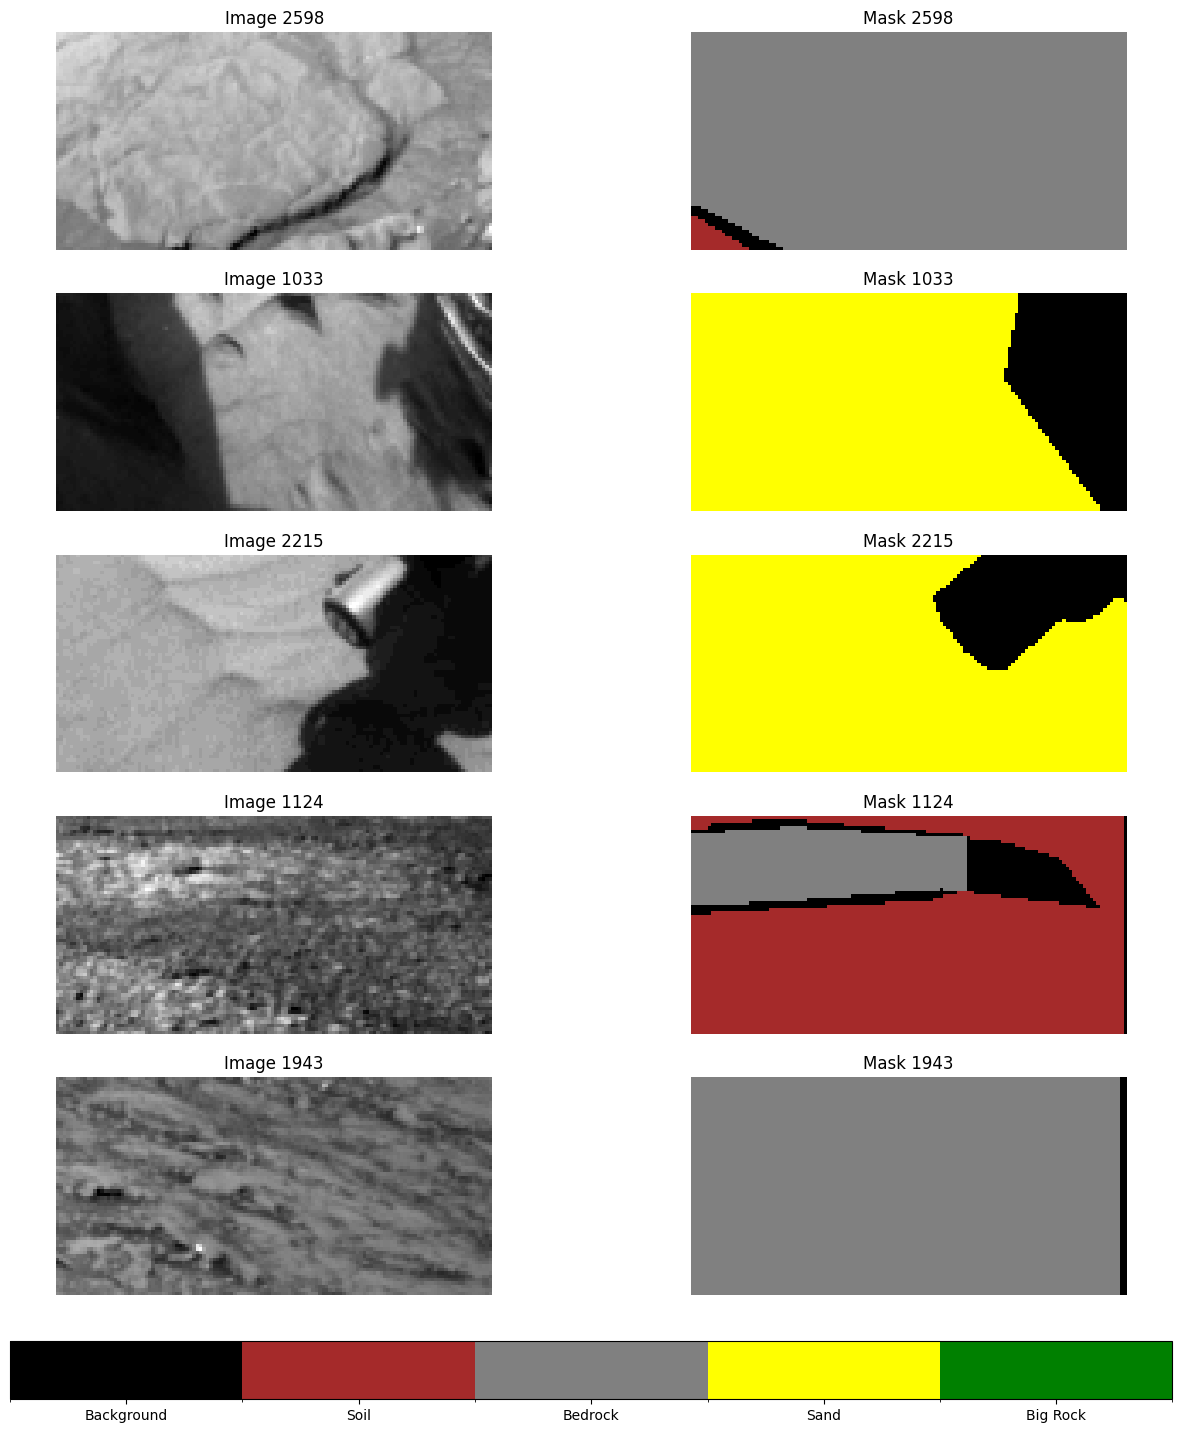

In [77]:
# Function to plot images with masks and legends
def plot_images_with_masks(images, masks, num_samples=5):
    indices = np.random.choice(len(images), num_samples, replace=False)
    plt.figure(figsize=(15, num_samples * 4))

    for i, idx in enumerate(indices):
        # Plot the image
        plt.subplot(num_samples, 2, i * 2 + 1)
        plt.imshow(images[idx], cmap="gray")
        plt.title(f"Image {idx}")
        plt.axis("off")

        # Plot the mask with the custom colormap
        plt.subplot(num_samples, 2, i * 2 + 2)
        mask_plot = plt.imshow(masks[idx], cmap=cmap, norm=norm)
        plt.title(f"Mask {idx}")
        plt.axis("off")

    # Add a legend to the mask plot
    cbar = plt.colorbar(mask_plot, ax=plt.gcf().axes, orientation='horizontal', pad=0.03)
    cbar.set_ticks(list(class_labels.keys()))
    cbar.set_ticklabels(list(class_labels.values()))
    plt.show()

# Plot random images with masks and a legend
plot_images_with_masks(X_train, y_train, num_samples=5)

In [78]:
# Reference mask (from image 142)
reference_mask = y_train[142]

# Find indices of identical masks
identical_indices = [i for i, mask in enumerate(y_train) if np.array_equal(mask, reference_mask)]

# Remove the identical images and masks
X_train = np.delete(X_train, identical_indices, axis=0)
y_train = np.delete(y_train, identical_indices, axis=0)

# Verify new dataset size
print(f"New dataset size: {X_train.shape[0]} images, {y_train.shape[0]} masks")

New dataset size: 2505 images, 2505 masks


Updated Class Distribution (pixels):
Class 0.0: 4988826 pixels (24.31%)
Class 1.0: 6957538 pixels (33.90%)
Class 2.0: 4776810 pixels (23.28%)
Class 3.0: 3770823 pixels (18.38%)
Class 4.0: 26963 pixels (0.13%)


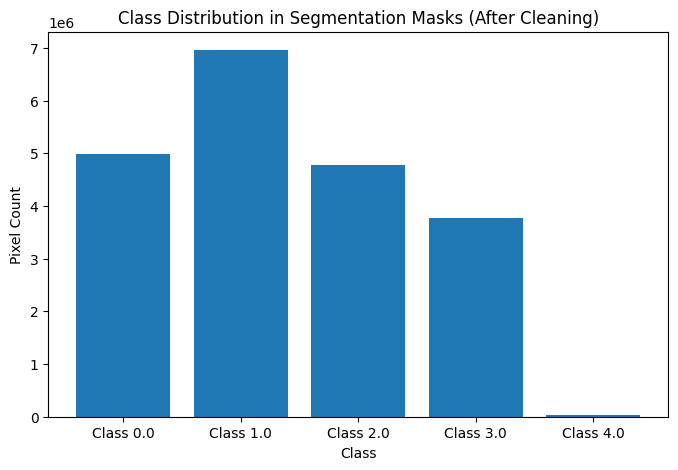

In [79]:
# Flatten the masks to calculate class distribution
flattened_masks = np.concatenate([mask.flatten() for mask in y_train])
class_counts = Counter(flattened_masks)

# Display class distribution
total_pixels = sum(class_counts.values())
print("Updated Class Distribution (pixels):")
for cls, count in sorted(class_counts.items()):
    print(f"Class {cls}: {count} pixels ({(count / total_pixels) * 100:.2f}%)")

# Bar plot for class distribution
classes = list(class_counts.keys())
counts = list(class_counts.values())

plt.figure(figsize=(8, 5))
plt.bar(classes, counts, tick_label=[f"Class {cls}" for cls in classes])
plt.xlabel("Class")
plt.ylabel("Pixel Count")
plt.title("Class Distribution in Segmentation Masks (After Cleaning)")
plt.show()

## 🛠️ Prepare Data

In [80]:
# Add color channel and rescale pixels between 0 and 1
X_train = X_train[..., np.newaxis] / 255.0
X_test = X_test[..., np.newaxis] / 255.0

input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
Number of classes: 5


In [81]:
# Stage 1: Split into training + validation and local test sets
X_train, X_test_local_val, y_train, y_test_local_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=42
)

# Stage 2: Split training + validation into training and validation sets
X_test_local, X_val, y_test_local, y_val = train_test_split(
    X_test_local_val, y_test_local_val, test_size=0.5, random_state=42
)

# Check the sizes of the splits
print(f"Training set size: {X_train.shape[0]} images")
print(f"Validation set size: {X_val.shape[0]} images")
print(f"Local test set size: {X_test_local.shape[0]} images")

Training set size: 2254 images
Validation set size: 126 images
Local test set size: 125 images


In [82]:
aug = A.Compose([
    A.HorizontalFlip(p=1),
    A.MaskDropout(p=0.25)
    ])

In [83]:
def visualize(original_image, original_mask):
    fontsize = 18

    augmented = aug(image=X_train[i], mask=y_train[i])
    image = augmented['image']
    mask = augmented['mask']

    f, ax = plt.subplots(2, 2, figsize=(8, 8))

    ax[0, 0].imshow(original_image, cmap='gray')
    ax[0, 0].set_title('Original image', fontsize=fontsize)

    ax[1, 0].imshow(original_mask, cmap=cmap, norm=norm)
    ax[1, 0].set_title('Original mask', fontsize=fontsize)

    ax[0, 1].imshow(image, cmap='gray')
    ax[0, 1].set_title('Transformed image', fontsize=fontsize)

    ax[1, 1].imshow(mask, cmap=cmap, norm=norm)
    ax[1, 1].set_title('Transformed mask', fontsize=fontsize)

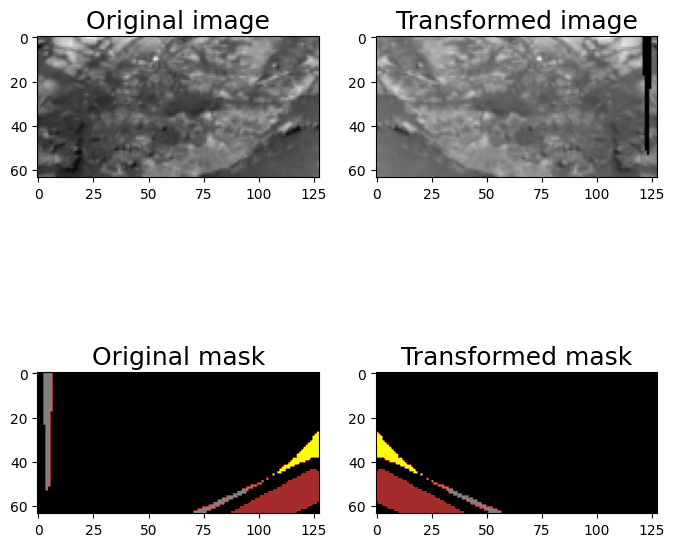

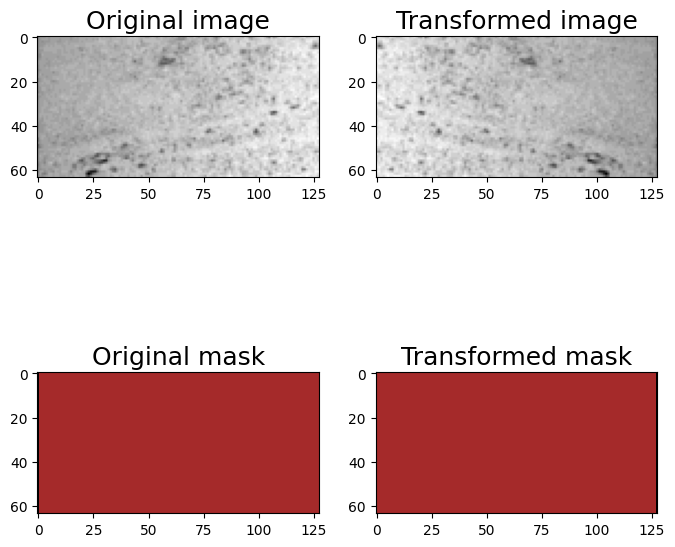

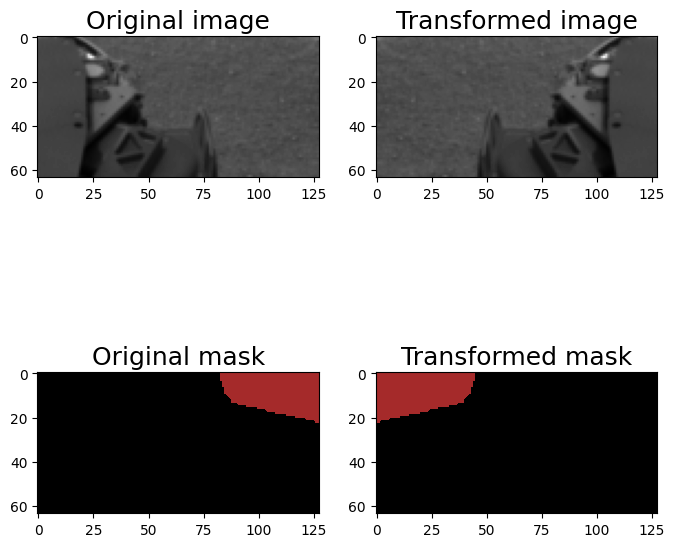

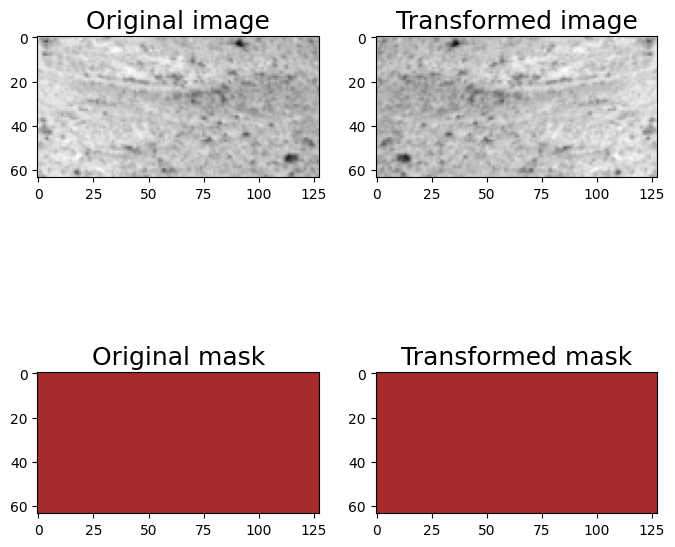

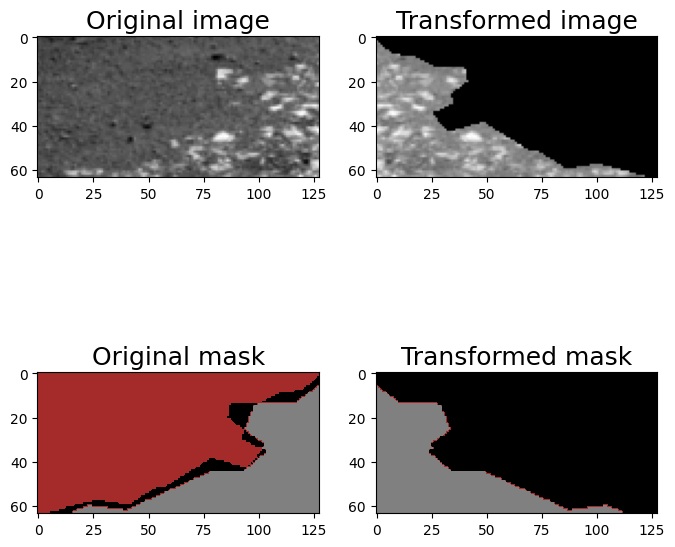

In [84]:
for i in range(5):
  visualize(X_train[i], y_train[i])

In [85]:
augmented_images = []
augmented_masks = []

for i in range(len(X_train)):
  augmented = aug(image=X_train[i], mask=y_train[i])
  augmented_images.append(augmented['image'])
  augmented_masks.append(augmented['mask'])

X_train_augmented = np.concatenate((X_train, augmented_images))
y_train_augmented = np.concatenate((y_train, augmented_masks))

print(X_train.shape)
print(y_train.shape)
print(X_train_augmented.shape)
print(y_train_augmented.shape)

(2254, 64, 128, 1)
(2254, 64, 128)
(4508, 64, 128, 1)
(4508, 64, 128)


In [86]:
def oversample_class(X, y, target_class=4, multiplier=4):
    # Find indices of samples containing the target class
    target_indices = [i for i, mask in enumerate(y) if target_class in mask]

    # Extract the samples containing the target class
    X_target = X[target_indices]
    y_target = y[target_indices]

    # Oversample by duplicating the samples
    X_oversampled = np.concatenate([X] + [X_target] * (multiplier - 1), axis=0)
    y_oversampled = np.concatenate([y] + [y_target] * (multiplier - 1), axis=0)

    # Shuffle the oversampled dataset
    indices = np.arange(len(X_oversampled))
    np.random.shuffle(indices)

    return X_oversampled[indices], y_oversampled[indices]

# Example Usage
# Assuming X_train_augmented and y_train_augmented are your numpy arrays
X_train_oversampled, y_train_oversampled = oversample_class(X_train_augmented, y_train_augmented)

# Check the new shape
print("Original shape:", X_train_augmented.shape, y_train_augmented.shape)
print("Oversampled shape:", X_train_oversampled.shape, y_train_oversampled.shape)

Original shape: (4508, 64, 128, 1) (4508, 64, 128)
Oversampled shape: (4859, 64, 128, 1) (4859, 64, 128)


In [87]:
# Convert NumPy arrays to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_augmented, y_train_augmented))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_local_dataset = tf.data.Dataset.from_tensor_slices((X_test_local, y_test_local))

In [88]:
# Function to print shapes of images and masks in a dataset
def print_dataset_shapes(dataset, name):
    for images, masks in dataset.take(1):
        print(f"{name} Dataset:")
        print(f"  Images shape: {images.shape}")
        print(f"  Masks shape: {masks.shape}")

# Print shapes of the datasets
print_dataset_shapes(train_dataset, "Training")
print_dataset_shapes(val_dataset, "Validation")
print_dataset_shapes(test_local_dataset, "Local Test")

Training Dataset:
  Images shape: (64, 128, 1)
  Masks shape: (64, 128)
Validation Dataset:
  Images shape: (64, 128, 1)
  Masks shape: (64, 128)
Local Test Dataset:
  Images shape: (64, 128, 1)
  Masks shape: (64, 128)


In [89]:
BATCH_SIZE = 8
BUFFER_SIZE = BATCH_SIZE * 2

# Prepare the training dataset
train_dataset = (
    train_dataset
    .shuffle(BUFFER_SIZE, seed=42)   # Shuffle the dataset
    .batch(BATCH_SIZE)      # Create batches
    .prefetch(tf.data.AUTOTUNE)  # Prefetch for performance
)

# Prepare the validation dataset (no shuffling or augmentation)
val_dataset = (
    val_dataset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Prepare the local test dataset (no shuffling or augmentation)
test_local_dataset = (
    test_local_dataset
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [90]:
@tf.keras.utils.register_keras_serializable()
def sparse_categorical_loss_ignore_bg(y_true, y_pred):
    # Create a mask to ignore background
    ignore_mask = tf.not_equal(y_true, 0)

    # Apply the mask
    y_true_filtered = tf.boolean_mask(y_true, ignore_mask)
    y_pred_filtered = tf.boolean_mask(y_pred, ignore_mask)

    # Compute sparse categorical cross-entropy
    loss = tf.keras.losses.sparse_categorical_crossentropy(
        y_true_filtered, y_pred_filtered
    )

    return tf.reduce_mean(loss)

In [91]:
def MiniASPP(input_tensor):
    """Mini-ASPP module with reduced complexity."""
    rates = [1, 2, 3]
    convs = [
        tfkl.Conv2D(128, (3, 3), dilation_rate=rate, padding="same", activation="relu")(input_tensor)
        for rate in rates
    ]
    conv_1x1 = tfkl.Conv2D(128, (1, 1), activation="relu")(input_tensor)
    concat = tfkl.Concatenate()(convs + [conv_1x1])
    output = tfkl.Conv2D(128, (1, 1), activation="relu")(concat)
    return output

@tf.keras.utils.register_keras_serializable()
class CustomLayer(tfk.layers.Layer):
    def call(self, x):
        avg_pool = tf.reduce_mean(x, axis=-1, keepdims=True)
        max_pool = tf.reduce_max(x, axis=-1, keepdims=True)
        return avg_pool, max_pool
    def get_config(self):
        config = super().get_config()
        # Add any additional configuration parameters here
        return config

def PixelSpatialAttention(input_tensor):
    """Pixel Spatial Attention (PSA) module."""
    avg_pool, max_pool = CustomLayer()(input_tensor)
    concat = tfkl.Concatenate(axis=-1)([avg_pool, max_pool])
    attention = tfkl.Conv2D(1, (7, 7), padding="same", activation="sigmoid")(concat)
    return input_tensor * attention

def SPPM(input_tensor):
    """Semantic Pyramid Pooling Module."""
    pool1 = tfkl.GlobalAveragePooling2D()(input_tensor)
    pool1 = tfkl.Reshape((1, 1, input_tensor.shape[-1]))(pool1)
    pool1 = tfkl.Conv2D(128, (1, 1), activation="relu")(pool1)
    pool1 = tfkl.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]), interpolation="bilinear")(pool1)

    pool2 = tfkl.Conv2D(128, (1, 1), activation="relu")(input_tensor)

    pool3 = tfkl.Conv2D(128, (3, 3), dilation_rate=2, padding="same", activation="relu")(input_tensor)

    pool4 = tfkl.Conv2D(128, (3, 3), dilation_rate=4, padding="same", activation="relu")(input_tensor)

    concat = tfkl.Concatenate()([pool1, pool2, pool3, pool4])
    output = tfkl.Conv2D(128, (1, 1), activation="relu")(concat)
    return output

def ShadowFeatureConnector(input_tensor):
    mini_aspp = MiniASPP(input_tensor)
    psa = PixelSpatialAttention(input_tensor)

    # Adjust the channel dimensions of psa to match mini_aspp
    psa_adjusted = tfkl.Conv2D(mini_aspp.shape[-1], (1, 1), activation='relu', padding='same')(psa)

    return tfkl.Add()([mini_aspp, psa_adjusted])

def DeepFeatureConnector(input_tensor):
    """Deep feature connector using SPPM."""
    return SPPM(input_tensor)

def marsseg_enhanced(input_shape=(64, 128, 1), num_classes=5):
    """Enhanced MarsSeg model implementation."""
    inputs = tfkl.Input(shape=input_shape)

    # Encoder
    x = tfkl.Conv2D(64, (3, 3), padding="same", activation="relu")(inputs)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)
    skip1 = x
    x = tfkl.MaxPooling2D((2, 2))(x)

    x = tfkl.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)
    skip2 = x
    x = tfkl.MaxPooling2D((2, 2))(x)

    encoder_output = tfkl.Conv2D(256, (3, 3), padding="same", activation="relu")(x)
    encoder_output = tfkl.BatchNormalization()(encoder_output)

    # Shadow Feature Connector
    shadow_features = ShadowFeatureConnector(encoder_output)

    # Deep Feature Connector
    deep_features = DeepFeatureConnector(encoder_output)

    # Combine shadow and deep features
    combined_features = tfkl.Add()([shadow_features, deep_features])

    # Decoder
    x = tfkl.Conv2DTranspose(128, (3, 3), strides=2, padding="same", activation="relu")(combined_features)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Concatenate()([x, skip2])
    x = tfkl.Conv2D(128, (3, 3), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)

    x = tfkl.Conv2DTranspose(64, (3, 3), strides=2, padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Concatenate()([x, skip1])
    x = tfkl.Conv2D(64, (3, 3), padding="same", activation="relu")(x)
    x = tfkl.BatchNormalization()(x)

    # Output Layer
    outputs = tfkl.Conv2D(num_classes, (1, 1), activation="softmax")(x)

    # Build model
    model = tfk.Model(inputs, outputs, name="EnhancedMarsSeg")
    return model

In [92]:
# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, image, label, frequency=5, cmap="jet", norm='norm'):
        super().__init__()
        self.image = image
        self.label = label
        self.frequency = frequency
        self.cmap = cmap
        self.norm = norm

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            image, label = self.image, self.label

            image = tf.expand_dims(image, 0)  # Add batch dimension
            pred = self.model.predict(image, verbose=0)

            y_pred = tf.math.argmax(pred, axis=-1).numpy()

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0, :, :, 0], cmap='gray')  # Assuming single-channel input
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            plt.imshow(label, cmap=self.cmap, norm=norm)  # Visualize class indices with colormap
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            plt.imshow(y_pred[0], cmap=self.cmap, norm=norm)  # Visualize class indices with colormap
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

viz_callback = VizCallback(X_val[17], y_val[17], cmap=cmap, norm=norm)

In [93]:
# Define the EarlyStopping callback
es_callback = EarlyStopping(
    monitor="val_mean_iou",
    patience=20,
    mode="max",
    restore_best_weights=True
)

# Define ReduceLROnPlateau callback
reduce_callback = ReduceLROnPlateau(
    monitor="val_mean_iou",
    factor=0.5,
    mode="max",
    patience=10,
    min_lr=1e-6,
    verbose=1
)

In [94]:
model = marsseg_enhanced()
model.summary()

Model: "EnhancedMarsSeg"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 64, 128, 1)     │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_20 (Conv2D)        │ (None, 64, 128, 64)    │            640 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_9     │ (None, 64, 128, 64)    │            256 │ conv2d_20[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_21 (Conv2D)        │ (None, 64, 128, 64)    │         36,928 │ batch_normalization_9… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_10    │ (None, 64, 128, 64)    │            256 │ conv2d_21[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 64, 64)     │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_22 (Conv2D)        │ (None, 32, 64, 128)    │         73,856 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_11    │ (None, 32, 64, 128)    │            512 │ conv2d_22[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_23 (Conv2D)        │ (None, 32, 64, 128)    │        147,584 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_12    │ (None, 32, 64, 128)    │            512 │ conv2d_23[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 16, 32, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 16, 32, 256)    │        295,168 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_13    │ (None, 16, 32, 256)    │          1,024 │ conv2d_24[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ custom_layer_1            │ [(None, 16, 32, 1),    │              0 │ batch_normalization_1… │
│ (CustomLayer)             │ (None, 16, 32, 1)]     │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling2d… │ (None, 256)            │              0 │ batch_normalization_1… │
│ (GlobalAveragePooling

 Total params: 2,887,016 (11.01 MB)

 Trainable params: 2,884,968 (11.01 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [95]:
loss = sparse_categorical_loss_ignore_bg

optimizer = tfk.optimizers.AdamW(learning_rate=0.0001)

mean_iou = tfk.metrics.MeanIoU(num_classes=num_classes, ignore_class=0, sparse_y_pred=False, name="mean_iou")

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy', mean_iou])

Epoch 1/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.4190 - loss: 1.2852 - mean_iou: 0.2352

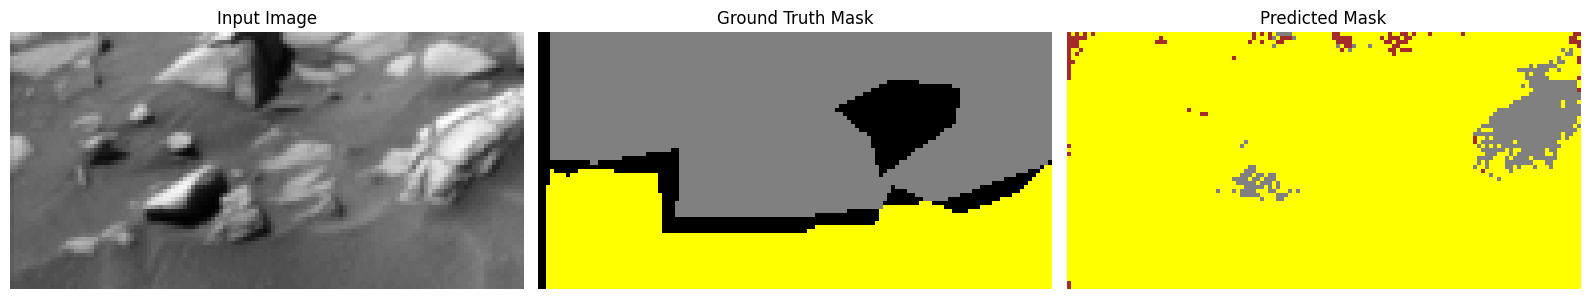

564/564 ━━━━━━━━━━━━━━━━━━━━ 65s 85ms/step - accuracy: 0.4191 - loss: 1.2848 - mean_iou: 0.2352 - val_accuracy: 0.4495 - val_loss: 1.6360 - val_mean_iou: 0.2741 - learning_rate: 1.0000e-04
Epoch 2/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 49s 42ms/step - accuracy: 0.5438 - loss: 0.8421 - mean_iou: 0.3487 - val_accuracy: 0.5316 - val_loss: 0.8291 - val_mean_iou: 0.3161 - learning_rate: 1.0000e-04
Epoch 3/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.5784 - loss: 0.6819 - mean_iou: 0.3857 - val_accuracy: 0.6182 - val_loss: 0.7935 - val_mean_iou: 0.3937 - learning_rate: 1.0000e-04
Epoch 4/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.5903 - loss: 0.5902 - mean_iou: 0.3990 - val_accuracy: 0.6429 - val_loss: 0.4965 - val_mean_iou: 0.4189 - learning_rate: 1.0000e-04
Epoch 5/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.6006 - loss: 0.5506 - mean_iou: 0.4099 - val_accuracy: 0.6849 - val_loss: 0.5265 - val_mean_iou: 0.4634 - learning_rate: 1.0000e-04
Epoch 6

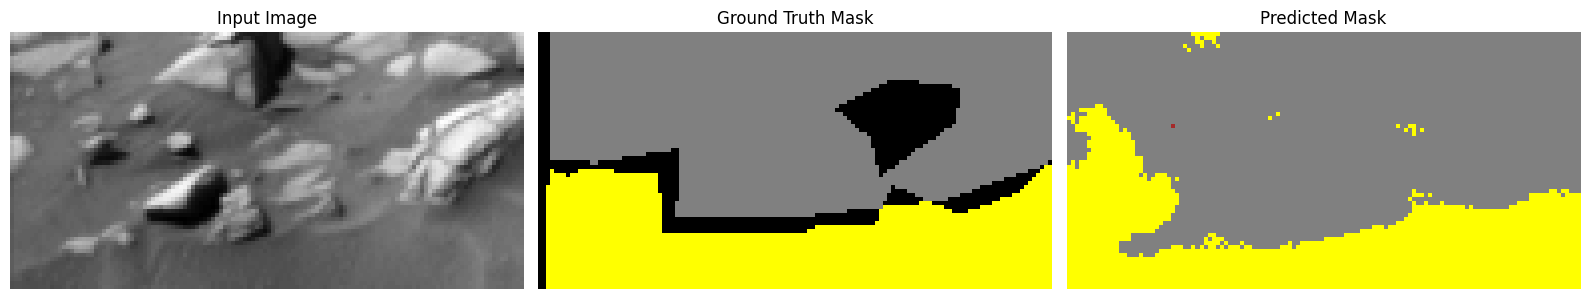

564/564 ━━━━━━━━━━━━━━━━━━━━ 25s 44ms/step - accuracy: 0.6097 - loss: 0.4970 - mean_iou: 0.4242 - val_accuracy: 0.6243 - val_loss: 0.5869 - val_mean_iou: 0.3932 - learning_rate: 1.0000e-04
Epoch 7/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.6284 - loss: 0.4374 - mean_iou: 0.4522 - val_accuracy: 0.6887 - val_loss: 0.5820 - val_mean_iou: 0.5893 - learning_rate: 1.0000e-04
Epoch 8/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.6251 - loss: 0.4426 - mean_iou: 0.4411 - val_accuracy: 0.6789 - val_loss: 0.4741 - val_mean_iou: 0.5758 - learning_rate: 1.0000e-04
Epoch 9/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.6359 - loss: 0.3894 - mean_iou: 0.4581 - val_accuracy: 0.6723 - val_loss: 0.4946 - val_mean_iou: 0.5631 - learning_rate: 1.0000e-04
Epoch 10/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6315 - loss: 0.3967 - mean_iou: 0.4651 - val_accuracy: 0.6790 - val_loss: 0.4119 - val_mean_iou: 0.5718 - learning_rate: 1.0000e-04
Epoch 

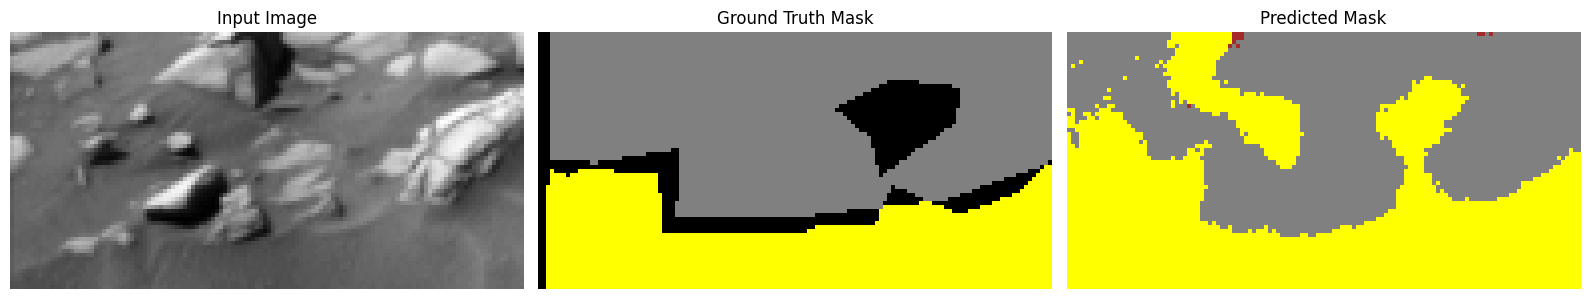

564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6400 - loss: 0.3391 - mean_iou: 0.4754 - val_accuracy: 0.7031 - val_loss: 0.3172 - val_mean_iou: 0.6120 - learning_rate: 1.0000e-04
Epoch 12/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.6465 - loss: 0.3205 - mean_iou: 0.4922 - val_accuracy: 0.6486 - val_loss: 0.6993 - val_mean_iou: 0.5305 - learning_rate: 1.0000e-04
Epoch 13/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.6509 - loss: 0.3195 - mean_iou: 0.4840 - val_accuracy: 0.6420 - val_loss: 0.5225 - val_mean_iou: 0.5198 - learning_rate: 1.0000e-04
Epoch 14/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6553 - loss: 0.2959 - mean_iou: 0.5036 - val_accuracy: 0.6778 - val_loss: 0.4137 - val_mean_iou: 0.5691 - learning_rate: 1.0000e-04
Epoch 15/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.6573 - loss: 0.2656 - mean_iou: 0.5199 - val_accuracy: 0.6980 - val_loss: 0.3374 - val_mean_iou: 0.6036 - learning_rate: 1.0000e-04
Epo

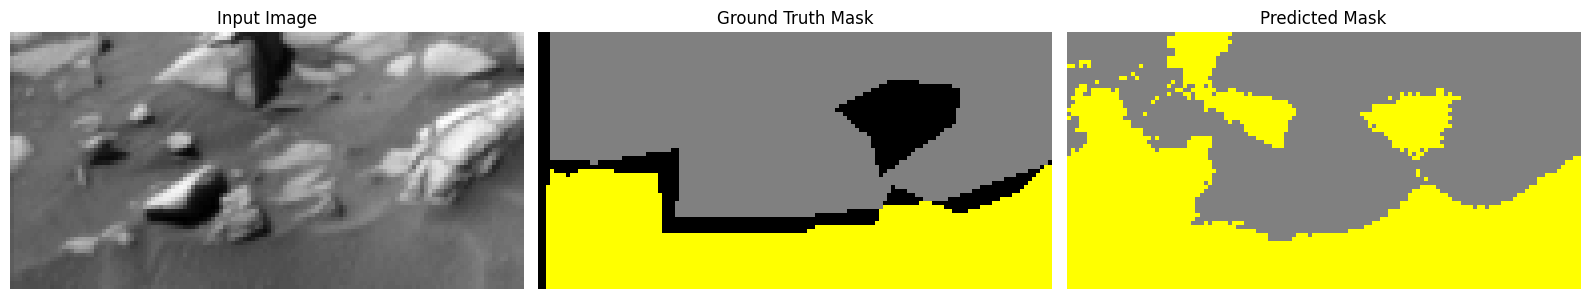

564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6641 - loss: 0.2509 - mean_iou: 0.5466 - val_accuracy: 0.7046 - val_loss: 0.3145 - val_mean_iou: 0.6132 - learning_rate: 1.0000e-04
Epoch 17/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6621 - loss: 0.2549 - mean_iou: 0.5292 - val_accuracy: 0.6126 - val_loss: 0.7813 - val_mean_iou: 0.4793 - learning_rate: 1.0000e-04
Epoch 18/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6688 - loss: 0.2282 - mean_iou: 0.5778 - val_accuracy: 0.6915 - val_loss: 0.3734 - val_mean_iou: 0.5969 - learning_rate: 1.0000e-04
Epoch 19/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6656 - loss: 0.2439 - mean_iou: 0.5436 - val_accuracy: 0.7013 - val_loss: 0.3192 - val_mean_iou: 0.6107 - learning_rate: 1.0000e-04
Epoch 20/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 42ms/step - accuracy: 0.6767 - loss: 0.1919 - mean_iou: 0.5624 - val_accuracy: 0.6882 - val_loss: 0.3365 - val_mean_iou: 0.5847 - learning_rate: 1.0000e-04
Epo

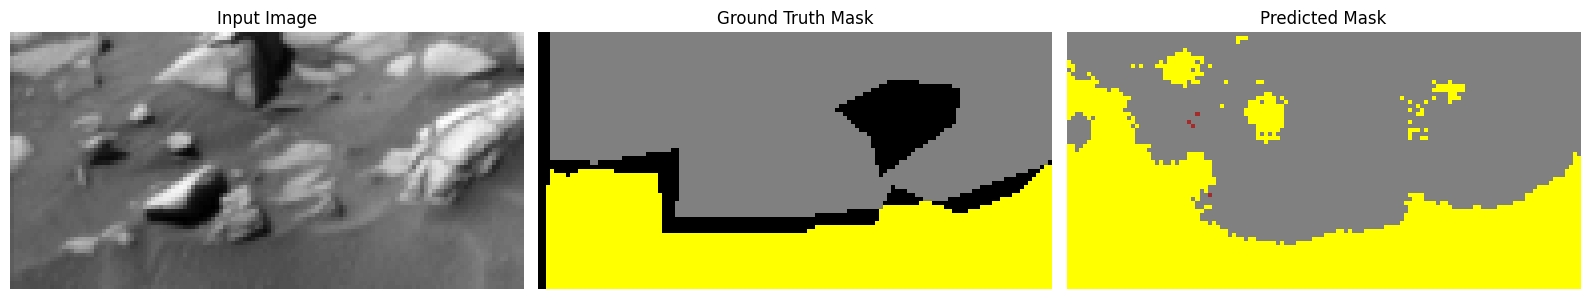

564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.6783 - loss: 0.1827 - mean_iou: 0.6000 - val_accuracy: 0.6615 - val_loss: 0.5121 - val_mean_iou: 0.5505 - learning_rate: 1.0000e-04
Epoch 22/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6800 - loss: 0.1921 - mean_iou: 0.6076 - val_accuracy: 0.6754 - val_loss: 0.4164 - val_mean_iou: 0.5684 - learning_rate: 1.0000e-04
Epoch 23/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.6800 - loss: 0.1852 - mean_iou: 0.5867 - val_accuracy: 0.7009 - val_loss: 0.2912 - val_mean_iou: 0.6092 - learning_rate: 1.0000e-04
Epoch 24/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.6879 - loss: 0.1493 - mean_iou: 0.6339 - val_accuracy: 0.6918 - val_loss: 0.3451 - val_mean_iou: 0.5920 - learning_rate: 1.0000e-04
Epoch 25/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.6849 - loss: 0.1649 - mean_iou: 0.6014 - val_accuracy: 0.6995 - val_loss: 0.3299 - val_mean_iou: 0.6031 - learning_rate: 1.0000e-04
Epo

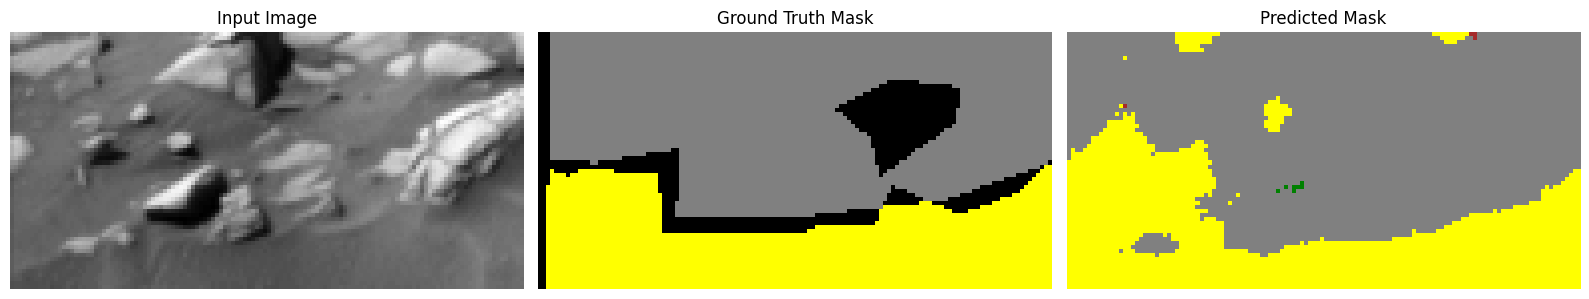


Epoch 26: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
564/564 ━━━━━━━━━━━━━━━━━━━━ 42s 44ms/step - accuracy: 0.6951 - loss: 0.1251 - mean_iou: 0.7750 - val_accuracy: 0.6987 - val_loss: 0.4102 - val_mean_iou: 0.6049 - learning_rate: 1.0000e-04
Epoch 27/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.6972 - loss: 0.1156 - mean_iou: 0.7159 - val_accuracy: 0.7184 - val_loss: 0.2672 - val_mean_iou: 0.6367 - learning_rate: 5.0000e-05
Epoch 28/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.7049 - loss: 0.0886 - mean_iou: 0.8273 - val_accuracy: 0.7121 - val_loss: 0.2798 - val_mean_iou: 0.6252 - learning_rate: 5.0000e-05
Epoch 29/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.7097 - loss: 0.0702 - mean_iou: 0.7122 - val_accuracy: 0.7058 - val_loss: 0.2821 - val_mean_iou: 0.6157 - learning_rate: 5.0000e-05
Epoch 30/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.7071 - loss: 0.0845 - mean_iou: 0.8479 - val_accuracy: 0.

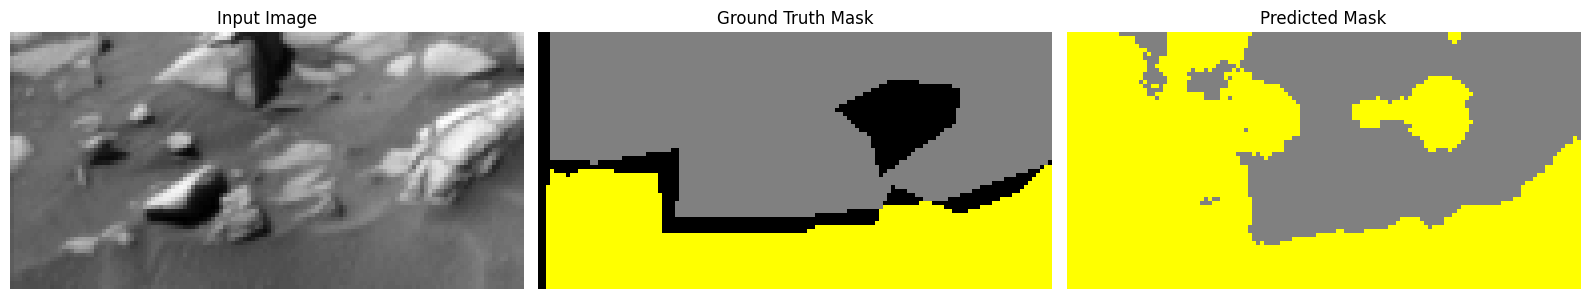

564/564 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7120 - loss: 0.0575 - mean_iou: 0.8186 - val_accuracy: 0.7101 - val_loss: 0.2888 - val_mean_iou: 0.6224 - learning_rate: 5.0000e-05
Epoch 32/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.7138 - loss: 0.0512 - mean_iou: 0.8862 - val_accuracy: 0.6973 - val_loss: 0.3356 - val_mean_iou: 0.6061 - learning_rate: 5.0000e-05
Epoch 33/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.7126 - loss: 0.0607 - mean_iou: 0.8818 - val_accuracy: 0.7070 - val_loss: 0.3763 - val_mean_iou: 0.6189 - learning_rate: 5.0000e-05
Epoch 34/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.7124 - loss: 0.0552 - mean_iou: 0.8880 - val_accuracy: 0.6575 - val_loss: 0.5012 - val_mean_iou: 0.5455 - learning_rate: 5.0000e-05
Epoch 35/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.7147 - loss: 0.0460 - mean_iou: 0.7939 - val_accuracy: 0.6953 - val_loss: 0.3960 - val_mean_iou: 0.6020 - learning_rate: 5.0000e-05
Epo

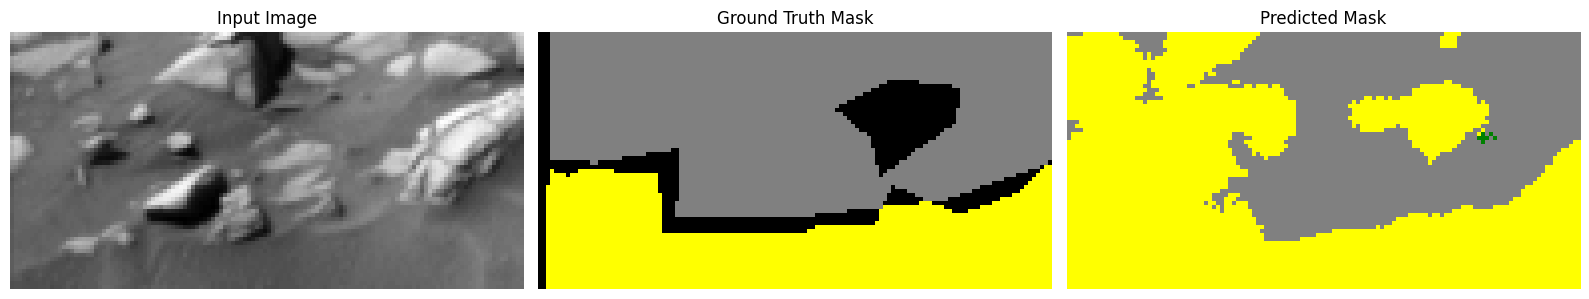

564/564 ━━━━━━━━━━━━━━━━━━━━ 25s 43ms/step - accuracy: 0.7171 - loss: 0.0391 - mean_iou: 0.8042 - val_accuracy: 0.6989 - val_loss: 0.3596 - val_mean_iou: 0.6047 - learning_rate: 5.0000e-05
Epoch 37/150
563/564 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7140 - loss: 0.0588 - mean_iou: 0.8951
Epoch 37: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.7138 - loss: 0.0589 - mean_iou: 0.8951 - val_accuracy: 0.7105 - val_loss: 0.2675 - val_mean_iou: 0.6228 - learning_rate: 5.0000e-05
Epoch 38/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 24s 43ms/step - accuracy: 0.7186 - loss: 0.0301 - mean_iou: 0.9338 - val_accuracy: 0.7090 - val_loss: 0.3051 - val_mean_iou: 0.6197 - learning_rate: 2.5000e-05
Epoch 39/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.7194 - loss: 0.0300 - mean_iou: 0.9339 - val_accuracy: 0.7078 - val_loss: 0.2744 - val_mean_iou: 0.6203 - learning_rate: 2.5000e-05
Epoch 40/150
564/564 ━━━━━━━━━━━━

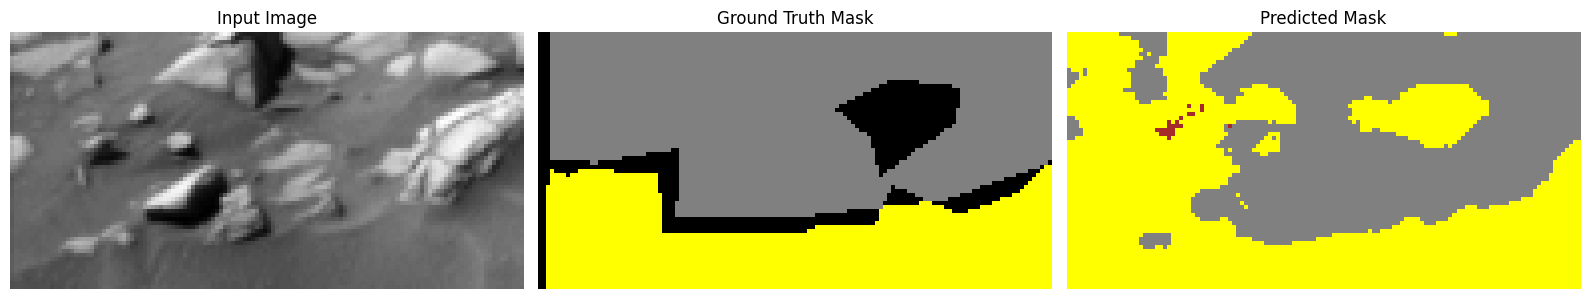

564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.7195 - loss: 0.0249 - mean_iou: 0.9434 - val_accuracy: 0.7062 - val_loss: 0.3540 - val_mean_iou: 0.6159 - learning_rate: 2.5000e-05
Epoch 42/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 0.7212 - loss: 0.0193 - mean_iou: 0.9480 - val_accuracy: 0.7152 - val_loss: 0.2761 - val_mean_iou: 0.6307 - learning_rate: 2.5000e-05
Epoch 43/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 43ms/step - accuracy: 0.7201 - loss: 0.0220 - mean_iou: 0.8368 - val_accuracy: 0.7063 - val_loss: 0.3544 - val_mean_iou: 0.6153 - learning_rate: 2.5000e-05
Epoch 44/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.7222 - loss: 0.0167 - mean_iou: 0.9547 - val_accuracy: 0.7114 - val_loss: 0.3181 - val_mean_iou: 0.6255 - learning_rate: 2.5000e-05
Epoch 45/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 41s 42ms/step - accuracy: 0.7226 - loss: 0.0146 - mean_iou: 0.9613 - val_accuracy: 0.7142 - val_loss: 0.3173 - val_mean_iou: 0.6283 - learning_rate: 2.5000e-05
Epo

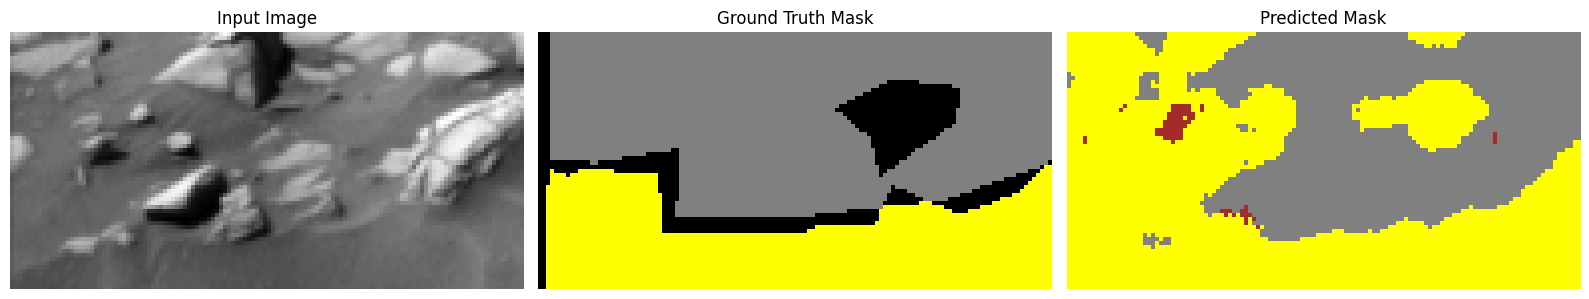

564/564 ━━━━━━━━━━━━━━━━━━━━ 42s 43ms/step - accuracy: 0.7186 - loss: 0.0309 - mean_iou: 0.9540 - val_accuracy: 0.7015 - val_loss: 0.3750 - val_mean_iou: 0.6061 - learning_rate: 2.5000e-05
Epoch 47/150
564/564 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7224 - loss: 0.0152 - mean_iou: 0.9593
Epoch 47: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-05.
564/564 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.7223 - loss: 0.0152 - mean_iou: 0.9593 - val_accuracy: 0.7147 - val_loss: 0.2956 - val_mean_iou: 0.6286 - learning_rate: 2.5000e-05


In [96]:
history = model.fit(train_dataset, epochs=150,  validation_data=val_dataset, callbacks=[viz_callback, es_callback, reduce_callback]).history

In [97]:
# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

Final validation Mean Intersection Over Union: 63.67%


In [98]:
model_filename = "weights.keras"
model.save(f"{model_filename}")

print(f"Model saved to {model_filename}")

Model saved to weights.keras


In [99]:
# Load deeplabv3 model without compiling
model_eval = tfk.models.load_model('weights.keras')

## Results

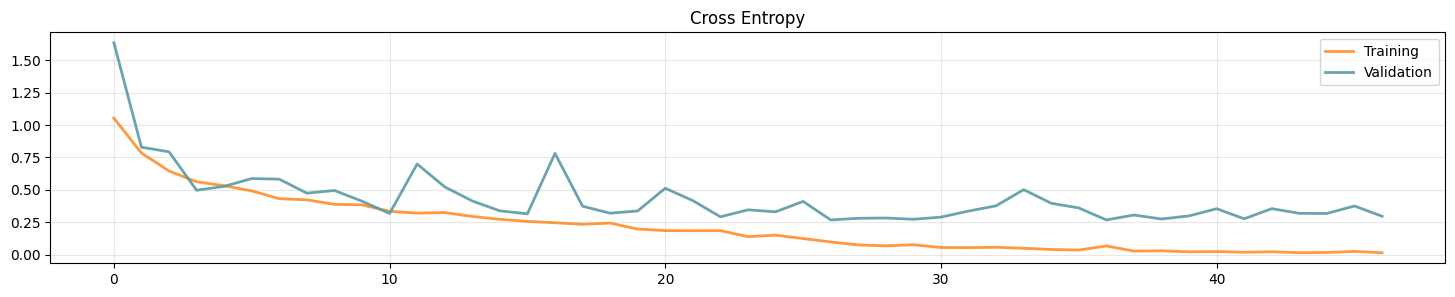

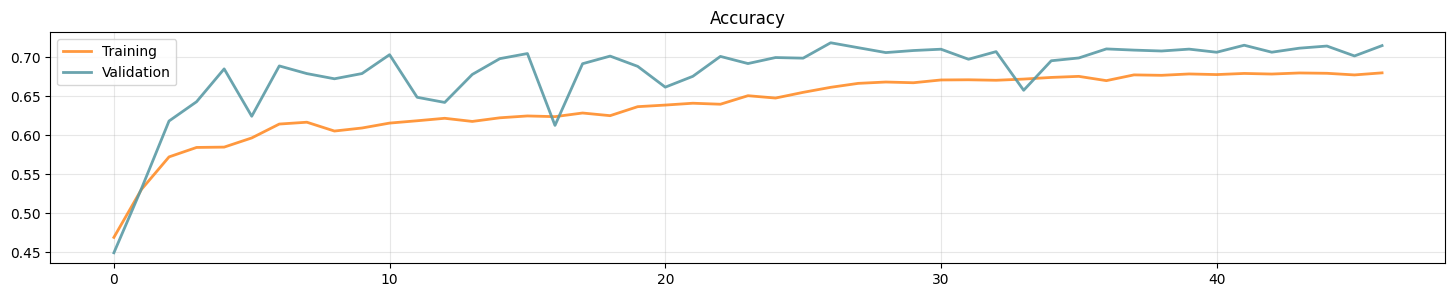

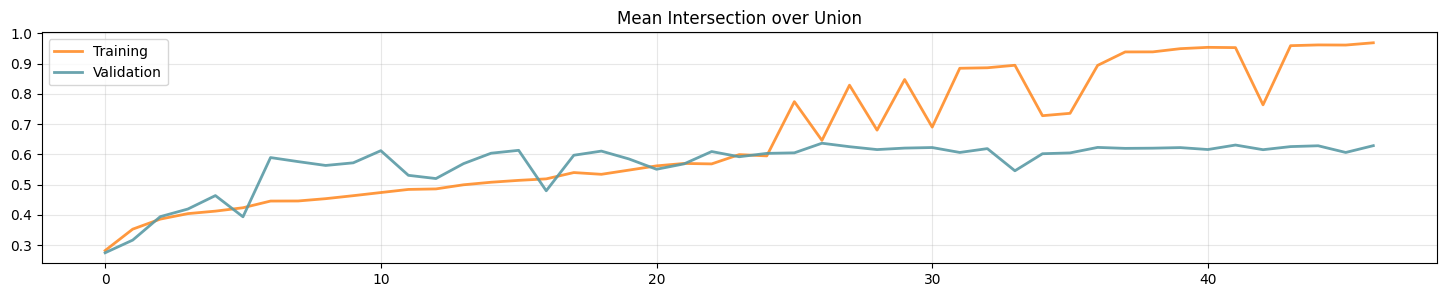

In [100]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [101]:
# Evaluate the model on the test set and print the results
test_loss, test_accuracy, test_mean_iou = model_eval.evaluate(test_local_dataset, verbose=0, batch_size=8)
print(f'Test Mean Intersection over Union: {round(test_mean_iou, 4)}')
print(f'Test Accuracy: {round(test_accuracy, 4)}')

Test Mean Intersection over Union: 0.6888
Test Accuracy: 0.6915


In [102]:
# Get predictions and true labels
all_preds = []
all_labels = []

for images, labels in test_local_dataset:
    preds = model_eval.predict(images, verbose=0)
    preds = tf.argmax(preds, axis=-1)  # Convert to class indices
    all_preds.append(preds.numpy())
    all_labels.append(labels.numpy())

# Flatten all predictions and labels
all_preds = np.concatenate([pred.flatten() for pred in all_preds])
all_labels = np.concatenate([label.flatten() for label in all_labels])

In [103]:
# Filter out background pixels (class 0)
foreground_mask = all_labels != 0
filtered_preds = all_preds[foreground_mask]
filtered_labels = all_labels[foreground_mask]

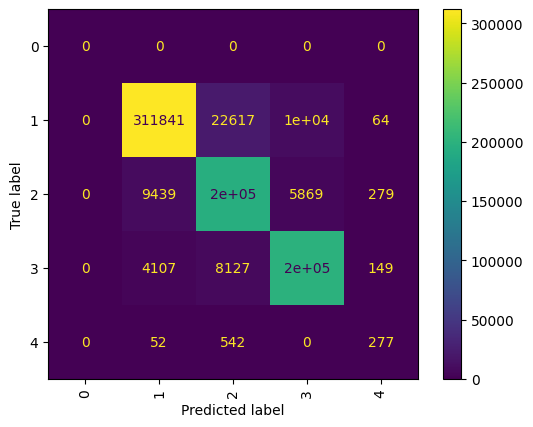

In [104]:
conf_matrix = confusion_matrix(filtered_labels, filtered_preds, labels=range(num_classes))

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(num_classes))
disp.plot(cmap='viridis', xticks_rotation='vertical')

In [105]:
# Compute IoU for each class
ious = []
for cls in range(num_classes):
    true_positive = conf_matrix[cls, cls]
    false_positive = conf_matrix[:, cls].sum() - true_positive
    false_negative = conf_matrix[cls, :].sum() - true_positive

    # Compute IoU for the current class
    union = true_positive + false_positive + false_negative
    iou = true_positive / union if union > 0 else 0.0
    ious.append(iou)
    print(f"Class {cls} IoU: {iou:.4f}")

# Exclude class 0 (background) from mean IoU
valid_ious = ious[1:]  # Exclude class 0
mean_iou = np.mean(valid_ious)
print(f"Mean IoU (excluding class 0): {mean_iou:.4f}")

Class 0 IoU: 0.0000
Class 1 IoU: 0.8701
Class 2 IoU: 0.8064
Class 3 IoU: 0.8755
Class 4 IoU: 0.2032
Mean IoU (excluding class 0): 0.6888


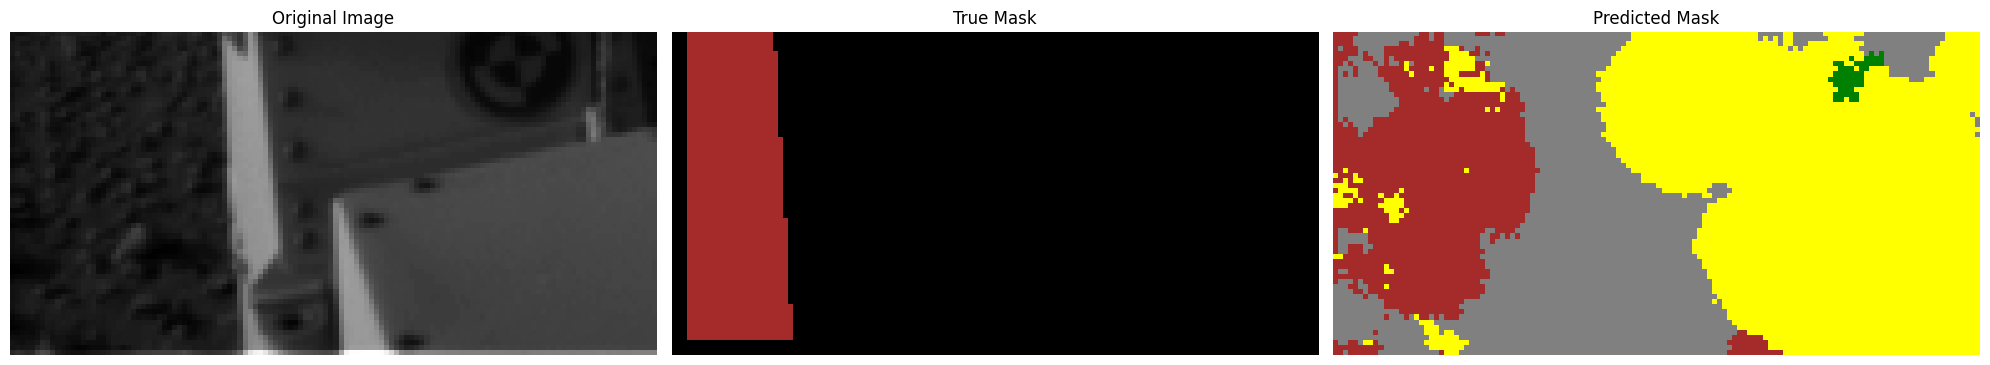

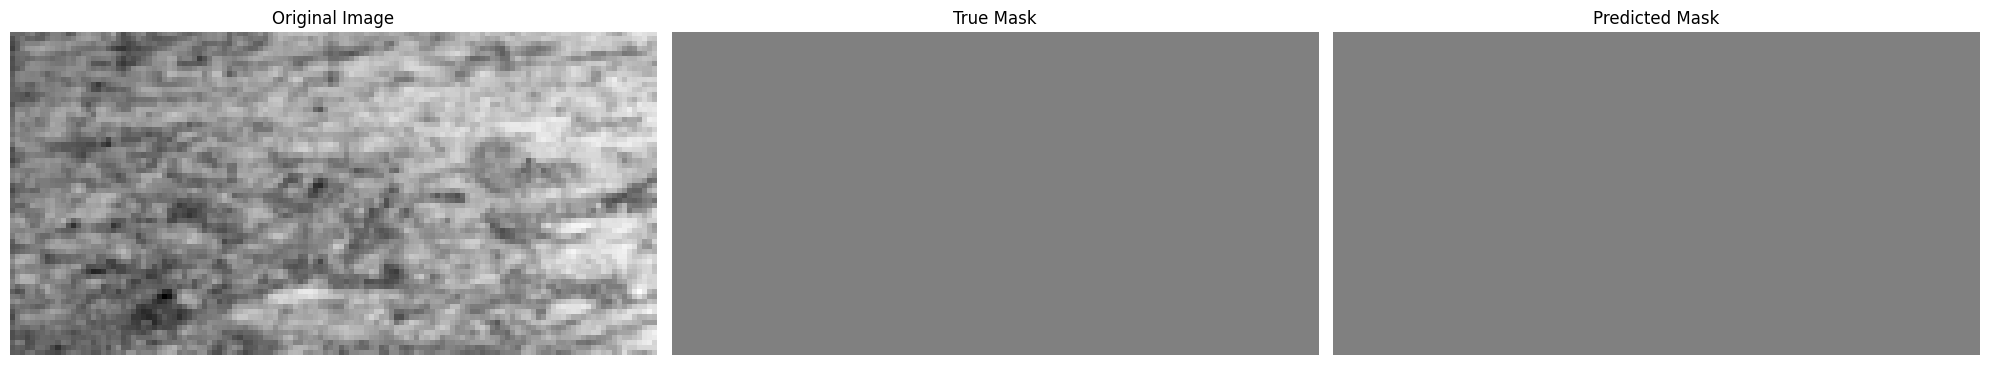

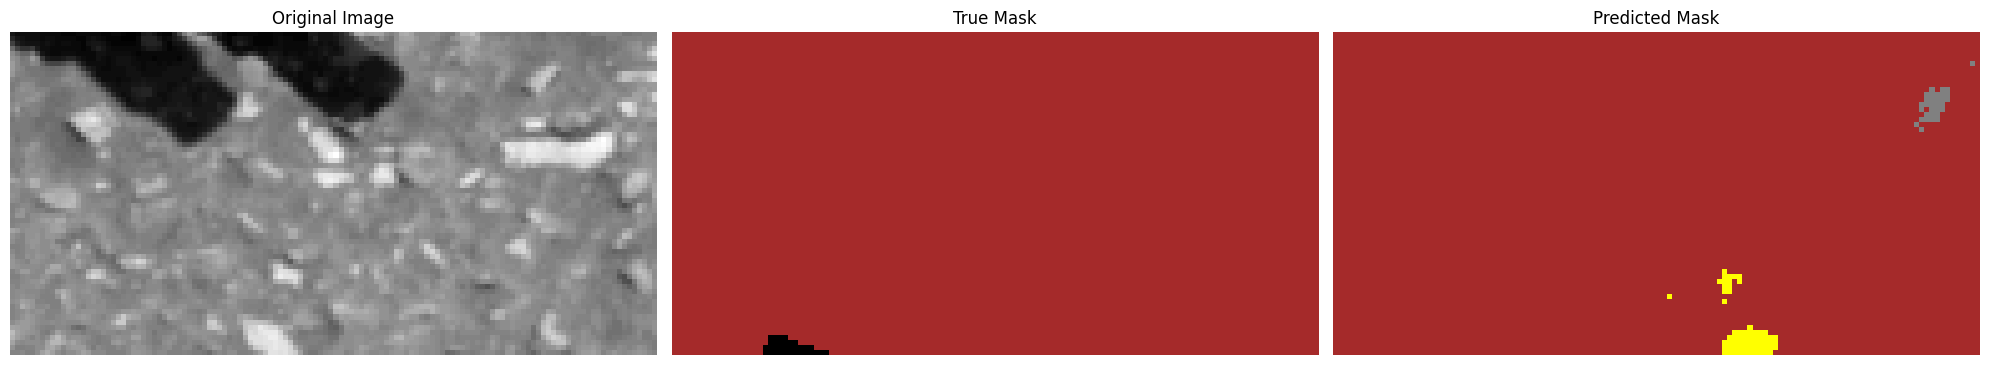

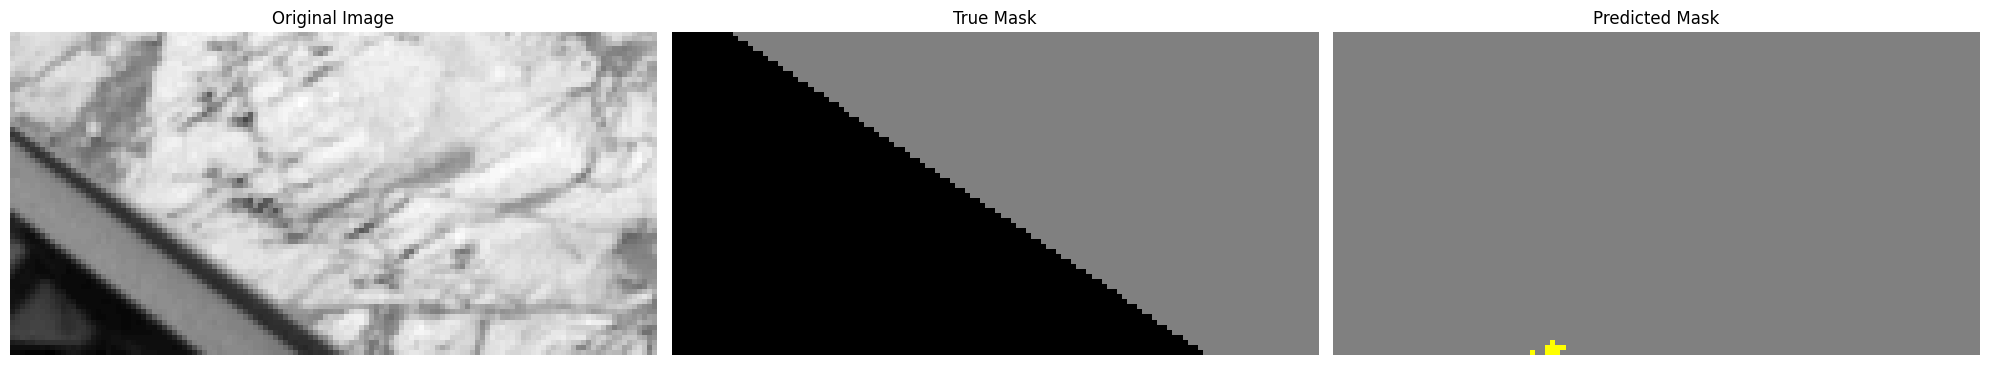

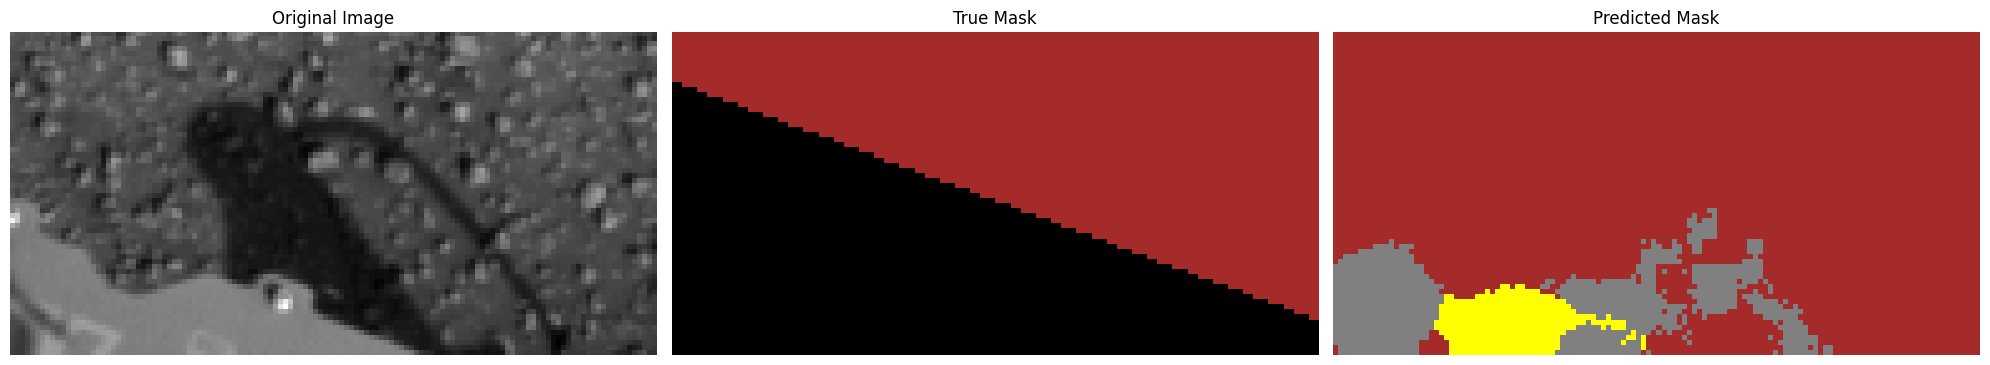

In [106]:
def plot_triptychs(dataset, model, num_samples=1, num_classes=5, cmap='jet', norm='norm'):
    # Take samples from the dataset
    samples = dataset.take(num_samples)

    for images, labels in samples:
        # Handle batches
        if len(images.shape) == 4:  # Batch of images
            images = images[0:1]  # Select the first image in the batch
            labels = labels[0:1]  # Select the first label in the batch

        # Generate predictions
        pred = model.predict(images, verbose=0)  # Shape: (batch_size, H, W, num_classes)
        pred = tf.argmax(pred, axis=-1).numpy()  # Convert predictions to class indices

        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 4))

        # Plot original image
        axes[0].imshow(images[0, :, :, 0], cmap='gray')  # Assuming single-channel images
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        # Plot true mask
        axes[1].imshow(labels[0], cmap=cmap, norm=norm)
        axes[1].set_title("True Mask")
        axes[1].axis('off')

        # Plot predicted mask
        axes[2].imshow(pred[0], cmap=cmap, norm=norm)
        axes[2].set_title("Predicted Mask")
        axes[2].axis('off')

        plt.tight_layout()
        plt.show()
        plt.close()

# Visualize 3 random samples from the test dataset
plot_triptychs(test_local_dataset, model_eval, num_samples=5, cmap=cmap, norm=norm)